# Image Classification Task for ML Internship 2023

Task - Your task is to train a ML model on the EuroSAT land cover classification dataset.

Dataset link- Dataset. The dataset contains 64x64 RGB images from Sentinel-2.
You can find references to the dataset here - https://github.com/phelber/EuroSAT

Training [Jupyter notebook]: Include all steps from loading the dataset, to
saving the model and evaluation metrics.

**Plan:**
  1. **Librairies import**
  2. **Data loading & preprocessing**
  4. **Model compilation**
  5. **Model trainning**

# Librairies import

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data.experimental import assert_cardinality
from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import shutil
from google.colab import drive
import zipfile

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading & Preprocessing

we begin by unzip the EUROSTAR.zip file

In [59]:
path_to_zip = '/content/drive/MyDrive/dataset/'

In [60]:
def extract_dataset_zip():
  with zipfile.ZipFile(path_to_zip + 'EuroSAT.zip', 'r') as zip_ref:
      zip_ref.extractall(path_to_zip)

#extract_dataset_zip()

In [61]:
#path of the dataset
dataset_path = '/content/drive/MyDrive/dataset/2750/'

In [62]:
#properties for the trainning
batch_size = 128
epochs = 50

#properties of the image
img_height = 64
img_width = 64

In [63]:
#classes
CLASSES = os.listdir(dataset_path)
for i, e in enumerate(CLASSES):
  print(f'classe {i} : {e}')

classe 0 : River
classe 1 : AnnualCrop
classe 2 : HerbaceousVegetation
classe 3 : Industrial
classe 4 : Residential
classe 5 : Highway
classe 6 : Pasture
classe 7 : Forest
classe 8 : SeaLake
classe 9 : PermanentCrop


In [64]:
# Loop over all classes and add all image paths to a list
all_image_paths = []
for class_name in CLASSES:
    class_path = os.path.join(dataset_path, class_name)
    image_names = os.listdir(class_path)
    #idx_class = CLASSES.index(class_name)
    for image_name in image_names:
        image_path = os.path.join(class_path, image_name)
        #all_image_paths.append((image_path,idx_class))
        all_image_paths.append((image_path,class_name))

# Randomly select 20 images for the test set
random.shuffle(all_image_paths)
test_image_paths = all_image_paths[:20]
train_val_image_paths = all_image_paths[20:4000]
#we take 4000 images (total)

# Split the remaining images into training and validation sets
random.shuffle(train_val_image_paths)
num_train_samples = int(0.8 * len(train_val_image_paths))
train_image_paths = train_val_image_paths[:num_train_samples]
val_image_paths = train_val_image_paths[num_train_samples:]

In [65]:
def set_to_csv(data, file_name):
      df = pd.DataFrame(data, columns=['path', 'label'])
      df.to_csv(file_name, index=False)
      return df

In [66]:
# Create files to store image paths and class labels for each set
train_file_path = "train.csv"
val_file_path = "validation.csv"
test_file_path = "test.csv"

In [67]:
train_df = set_to_csv(train_image_paths, train_file_path)
val_df = set_to_csv(val_image_paths, val_file_path)
test_df = set_to_csv(test_image_paths, test_file_path)

In [68]:
#preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# Normalize the validation set
val_datagen = ImageDataGenerator(rescale=1./255)

In [69]:
# Create a training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='',
    x_col='path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 3184 validated image filenames belonging to 10 classes.


In [70]:
# Create a validation data generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='',
    x_col='path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 796 validated image filenames belonging to 10 classes.


In [71]:
num_images_train = len(train_generator.filepaths)
print("Number of images:", num_images_train)
num_images_validation = len(val_generator.filepaths)
print("Number of images:", num_images_validation)

Number of images: 3184
Number of images: 796


In [72]:
nb = len(CLASSES)

convert generator to tf dataset (for option such as cache, prefetch...)

In [73]:
# train_ds = tf.data.Dataset.from_generator(
#     lambda: train_generator,
#     output_types = (tf.float32, tf.float32),
#     output_shapes = ([batch_size, img_height, img_width, 3], [batch_size, nb]),
# )

# valid_ds = tf.data.Dataset.from_generator(
#     lambda: val_generator,
#     output_types = (tf.float32, tf.float32),
#     output_shapes = ([batch_size, img_height, img_width, 3], [batch_size, nb]),
# )

In [74]:
#attention RAM prefetch
#AUTOTUNE = tf.data.experimental.AUTOTUNE

In [75]:
#train_ds = train_ds.apply(assert_cardinality(num_images_train//batch_size)).prefetch(buffer_size=1024).cache()#.batch(BS,num_parallel_calls=True)
#valid_ds = valid_ds.apply(assert_cardinality(num_images_validation//batch_size)).prefetch(buffer_size=1024).cache()#.batch(BS,num_parallel_calls=True)

# Model compilation

In [76]:
#differents pretrained models
print([model_name for model_name in dir(applications) if not model_name.startswith('_')])

['ConvNeXtBase', 'ConvNeXtLarge', 'ConvNeXtSmall', 'ConvNeXtTiny', 'ConvNeXtXLarge', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', 'EfficientNetV2B3', 'EfficientNetV2L', 'EfficientNetV2M', 'EfficientNetV2S', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'ResNetRS101', 'ResNetRS152', 'ResNetRS200', 'ResNetRS270', 'ResNetRS350', 'ResNetRS420', 'ResNetRS50', 'VGG16', 'VGG19', 'Xception', 'convnext', 'densenet', 'efficientnet', 'efficientnet_v2', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'regnet', 'resnet', 'resnet_rs', 'resnet_v2', 'vgg16', 'vgg19', 'xc

In [77]:
#I chose to add layers at the end of the model
def Model_added_layers(pretrained_model):
  last = pretrained_model.get_layer(pretrained_model.layers[-1].name).output# last layers of the pretrained model
  x = tf.keras.layers.BatchNormalization()(last)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(40, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  #output layers must correspond to the number of classes
  outputs = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)
  model = tf.keras.Model(pretrained_model.input, outputs)
  return model

In [78]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [79]:
model = Model_added_layers(base_model)

In [80]:
#model.summary()

In [81]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [82]:
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Model trainning

In [106]:
#we need to save the best model during the trainning
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
mc = ModelCheckpoint('/content/drive/MyDrive/best_model_EuroStar.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [107]:
#entrainement refais 5 fois (5 itérations)
history = model.fit(train_generator,
                    validation_data=val_generator, 
                    epochs=epochs, 
                    #batch_size=batch_size,
                    steps_per_epoch=num_images_train//batch_size + 1,
                    validation_steps=num_images_validation//batch_size + 1,
                    verbose=1, 
                    callbacks = [es,mc])

                    #steps_per_epoch=int(num_images_train / batch_size),
                    #validation_steps=int(num_images_validation / batch_size))

#saved_model1 = load_model('best_model1.h5')

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9840
Epoch 1: val_loss improved from inf to 1.41087, saving model to /content/drive/MyDrive/best_model_EuroStar.h5
25/25 [==============================] - 10s 403ms/step - loss: 0.0509 - accuracy: 0.9840 - val_loss: 1.4109 - val_accuracy: 0.7764
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9918
Epoch 2: val_loss improved from 1.41087 to 1.20070, saving model to /content/drive/MyDrive/best_model_EuroStar.h5
25/25 [==============================] - 10s 395ms/step - loss: 0.0302 - accuracy: 0.9918 - val_loss: 1.2007 - val_accuracy: 0.8229
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9903
Epoch 3: val_loss improved from 1.20070 to 1.11384, saving model to /content/drive/MyDrive/best_model_EuroStar.h5
25/25 [==============================] - 11s 427ms/step - loss: 0.0386 - accuracy: 0.9903 - val_loss: 1.1138 - val_a

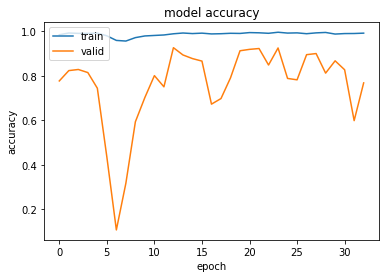

In [108]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

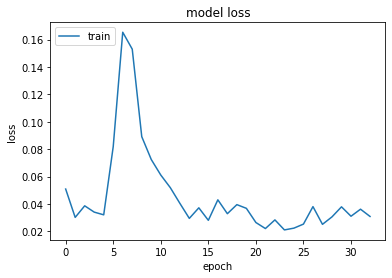

In [109]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

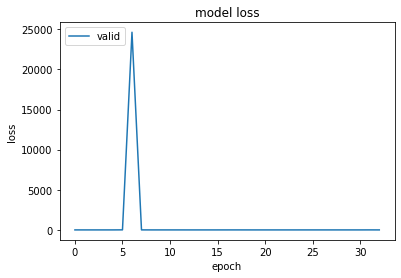

In [111]:
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['valid'], loc='upper left')
plt.show()